In [77]:
!pip install --quiet optuna

optuna모델

---

하이퍼파라미터 최적화 태스크를 도와주는 프레임워크이다.

*   Python 조건, 루프 및 구문을 사용하여 최적의 하이퍼파라미터 자동 검색
*   빠른 결과를 위해 넓은 공간을 효율적으로 검색하고 효율이 떨어지는 방법은 알아서 제거합니다.
*   별도의 코드 수정 없이 여러 스레드 또는 프로세스에 대한 하이퍼파라미터 검색 병렬화



In [78]:
import optuna

optuna.__version__

'3.0.2'

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
from tqdm import tqdm #진행률바
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge #선형 모델
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder #문자를 숫자로 인코딩
from sklearn.model_selection import TimeSeriesSplit #변수n을 입력, n번의 반복으로 교차검즘을 할 것인지 정하는 것
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
data = '/content/drive/MyDrive/transaction'

In [82]:
train_data_path = join(data, 'train.csv')
test_data_path = join(data, 'test.csv')
park_data_path = join(data, 'park.csv')
care_data_path = join(data, 'day_care_center.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
park = pd.read_csv(park_data_path)
care= pd.read_csv(care_data_path)

print(train.shape, test.shape, park.shape, care.shape)

(1216553, 13) (5463, 12) (1359, 13) (7551, 11)


In [83]:
train.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


In [84]:
test.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,5.463000e+03,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000
mean,1.167126e+06,6287.570932,79.495250,2000.431082,201710.228446,8.266886
std,4.075365e+04,3624.756304,32.935434,9.982040,2.798195,6.082475
min,1.092791e+06,12.000000,10.321500,1961.000000,201701.000000,-1.000000
25%,1.134296e+06,3278.000000,59.760000,1995.000000,201709.000000,4.000000
50%,1.167937e+06,6091.000000,81.720000,2002.000000,201712.000000,7.000000
75%,1.202560e+06,9416.500000,84.970000,2007.000000,201712.000000,11.000000
max,1.234930e+06,12652.000000,273.860000,2017.000000,201712.000000,55.000000


In [85]:
train.loc[train['transaction_real_price']==820000] #제일 비싼 아파트

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
23603,23603,11320,서울특별시,한남동,810,한남더힐,한남동 810 한남더힐,244.749,2011,201612,21~31,3,820000


In [86]:
regex = "\(.*\)|\s-\s.*" 
for i in tqdm(range(len(train))):
   train.at[i, 'apt'] = re.sub(regex, '', train.at[i, 'apt'])
for i in tqdm(range(len(test))):
   test.at[i, 'apt'] = re.sub(regex, '', test.at[i, 'apt'])  
#apt칼럼의 소괄호제거 하는 명령어

100%|██████████| 5463/5463 [00:00<00:00, 59714.23it/s]


In [87]:
train['apt'].value_counts()[:60] #아파트 이름이 많이 겹치는 것을 확인 할 수 있다.

현대            17716
한신            10135
삼성             6771
대우             6390
신동아            6386
두산             5801
우성             5781
주공2            5669
삼성래미안          5483
벽산             4651
대림             4582
동원로얄듀크         4430
경남             4030
삼환             3896
극동             3771
삼익             3583
롯데캐슬           3570
쌍용             3409
코오롱            3320
한양             3231
오륙도에스케이뷰       3220
성원             3112
파크리오           3094
청구             3006
몰운대            2886
동아             2804
경남아너스빌         2657
현대3            2595
삼정그린코아         2585
대림e-편한세상       2583
에스케이북한산시티      2572
다대동롯데캐슬몰운대     2536
주공5            2479
한진             2464
현대1            2450
미성             2448
엘지메트로시티1       2359
개포주공 1단지       2356
한일유앤아이         2325
삼익비치           2295
롯데낙천대          2292
사직쌍용예가         2288
중앙하이츠          2278
개금주공2          2266
잠실엘스           2258
리센츠            2234
중계그린1단지        2175
관악드림           2110
롯데             2045
쌍용스윗닷홈         2041


In [88]:
# 같은 아파트 이름을 갖는 수를 저장하는 apt_counts 열 생성
train['apt_counts'] = 0
train.groupby('apt')['apt_counts'].count()
train = pd.merge(train, train.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

test['apt_counts'] = 0
test.groupby('apt')['apt_counts'].count()
test = pd.merge(test, test.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

train.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000,1
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500,13


In [89]:
#top 10 시공사 아파트 여부를 나타내는 컬럼 생성
train['top10'] = 0
test['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

train['apt'] = train['apt'].fillna('others')
#top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
    train.loc[train['apt'].str.contains(brand), 'top10'] = 1
    test.loc[test['apt'].str.contains(brand), 'top10'] = 1

In [90]:
train.head(1)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts,top10
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13,0


In [91]:
# 데이터에 많이 있는 아파트 대표 25개 리스트
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names

# `apt_names_list`의 키워드에 해당하는 아파트명이 있는지 여부를 나타내는 새로운 컬럼 생성
train['transformed'] = False
test['transformed'] = False

# `apt_names_list`의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명을 통일함
# 그리고 `transformed` 컬럼값을 True로 변경
for a in tqdm(apt_names_list):
    train.loc[train['apt'].str.contains(a), 'apt'] = a
    test.loc[test['apt'].str.contains(a), 'apt'] = a
    train.loc[train['apt'].str.contains(a), 'transformed'] = True
    test.loc[test['apt'].str.contains(a), 'transformed'] = True

# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경
for a in tqdm(apt_names):
    train.loc[~train['transformed'], 'apt'] = 'others'
    test.loc[~test['transformed'] , 'apt'] = 'others'

100%|██████████| 25/25 [00:00<00:00, 25.44it/s]


In [92]:
train['apt'].value_counts() #주요 건설사 이외의 건설사 명을 other로 지정

others          653503
현대               81824
주공               65937
래미안              32743
한신               27481
벽산               26968
우성               24524
롯데캐슬             24053
삼성               20067
sk|SK|에스케이       19709
두산               19501
삼익               18708
푸르지오             18416
쌍용               18256
대림               18194
대우               17786
이편한|e편한|e-편한     14337
신동아              14049
힐스테이트            11985
자이               11719
엘지               10938
경남               10875
코오롱               8602
아이파크              7989
성원                7601
더샵                6977
삼환                6073
동원로얄듀크            6070
파크리오              3094
잠실                2606
동성                2228
데시앙               2222
양지                1033
그레이스               393
동궁리치웰               92
Name: apt, dtype: int64

In [93]:
print(train['apt'].nunique(), test['apt'].nunique())#train과 test의 건설사 개수가 통일 된 것을 확인 할 수 있다.

35 35


In [94]:
apt_price = train.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

for i, a in enumerate(list(apt_price.index)):
    train.loc[train['apt'] == a, 'apt'] = i # 라벨 인코딩
    test.loc[test['apt'] == a, 'apt'] = i
apt_price = train.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

변환전
 apt
잠실      91273.525326
파크리오    88739.646736
자이      79838.112467
래미안     64184.531289
아이파크    63115.982726
Name: transaction_real_price, dtype: float64
변환후
 apt
0    91273.525326
1    88739.646736
2    79838.112467
3    64184.531289
4    63115.982726
Name: transaction_real_price, dtype: float64


In [95]:
train.head(1)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts,top10,transformed
0,0,7622,서울특별시,신교동,6-13,23,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13,0,False


In [96]:
train.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04,1.358148e+03,1.234225e-01
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04,2.521461e+03,3.289217e-01
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02,1.000000e+00,0.000000e+00
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04,2.130000e+02,0.000000e+00
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04,5.950000e+02,0.000000e+00
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04,1.366000e+03,0.000000e+00
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05,1.771600e+04,1.000000e+00


In [97]:
apt_price = train.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)#agg 여러개의 함수를 여러열에 적용(매핑과 비슷한 메커니즘)
print('변환전\n', apt_price[:5])

for i, a in enumerate(list(apt_price.index)):
  train.loc[train['apt'] == a, 'apt'] = i #라벨 인코딩
  test.loc[test['apt'] == a, 'apt'] = i
apt_price = train.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

변환전
 apt
0    91273.525326
1    88739.646736
2    79838.112467
3    64184.531289
4    63115.982726
Name: transaction_real_price, dtype: float64
변환후
 apt
0    91273.525326
1    88739.646736
2    79838.112467
3    64184.531289
4    63115.982726
Name: transaction_real_price, dtype: float64


In [98]:
train.head(1)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts,top10,transformed
0,0,7622,서울특별시,신교동,6-13,23,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13,0,False


In [99]:
train.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04,1.358148e+03,1.234225e-01
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04,2.521461e+03,3.289217e-01
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02,1.000000e+00,0.000000e+00
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04,2.130000e+02,0.000000e+00
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04,5.950000e+02,0.000000e+00
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04,1.366000e+03,0.000000e+00
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05,1.771600e+04,1.000000e+00


*  날짜 관련 컬럼은 year_of_completion, transaction_year_month, transaction_date
*  transaction_date는 010, 1120, 21~30 총 세가지로 이루어져 있는데, 가격에 크게 영향을 미칠 것 같지 않아 제외합니다. 각 컬럼의 최대/최소가 아래와 같다.
*  year_of_completion


> 최소연도: 1961년


> 최대연도: 2017년

*  transaction_year_month


> 최소연도: 2008년 1월


> 최대연도: 2017년 11월 임을 확인합니다

*  최대연도에서 최소연도를 빼면 정수형 라벨인코딩이 완성
*  사용하지 않을 열도 미리 제거.
*  test 완공연도는 train 데이터와 동일하기 때문에 상관없습니다.
*  대신 거래연월이 2017년 01월부터 12월까지로만 이루어져 있기 때문에, 최소값을 빼면 train 라벨인코딩과 다른 값이 됩니다.
*  따라서 test의 거래연월에서 2017을 뺀 값에서 201701의 인코딩 값을 더한다.

In [100]:
test_start = train.loc[train['transaction_year_month'] == 201701,'transaction_year_month'].index[0]
#거래연월일 인덱스 저장

In [101]:
  # 완공연도에서 최소연도를 뺌으로써 완공연도 라벨인코딩
print('변환전\n', train['year_of_completion'].unique()[:5])
train['year_of_completion'] = train['year_of_completion'] - train['year_of_completion'].min()
test['year_of_completion'] = test['year_of_completion'] - test['year_of_completion'].min()
print('변환후\n', train['year_of_completion'].unique()[:5])

# 연월 증가하는 순으로 라벨 인코딩
print('train 변환전\n', train['transaction_year_month'].unique()[:5])
print('test 변환전\n', test['transaction_year_month'].unique()[:5])
le = LabelEncoder()
train['transaction_year_month'] = le.fit_transform(train['transaction_year_month'])
# test는 다음과 같이 처리
test['transaction_year_month'] = test['transaction_year_month'] - test['transaction_year_month'].min() + train.at[test_start, 'transaction_year_month']
print('train 변환후\n', train['transaction_year_month'].unique()[:5])
print('test 변환후\n', test['transaction_year_month'].unique()[:5])

# 필요없는 열 제거
train_df = train.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)
test_df = test.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)

변환전
 [2002 1973 2007 2003 2004]
변환후
 [41 12 46 42 43]
train 변환전
 [200801 200802 200803 200804 200805]
test 변환전
 [201711 201708 201710 201707 201712]
train 변환후
 [0 1 2 3 4]
test 변환후
 [118 115 117 114 119]


In [102]:
train.head(5)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts,top10,transformed
0,0,7622,서울특별시,신교동,6-13,23,신교동 6-13 신현(101동),84.82,41,0,21~31,2,37500,13,0,False
1,1,5399,서울특별시,필운동,142,23,필운동 142 사직파크맨션,99.17,12,0,1~10,6,20000,1,0,False
2,2,3578,서울특별시,필운동,174-1,23,필운동 174-1 두레엘리시안,84.74,46,0,1~10,6,38500,13,0,False
3,3,10957,서울특별시,내수동,95,23,내수동 95 파크팰리스,146.39,42,0,11~20,15,118000,55,0,False
4,4,10639,서울특별시,내수동,110-15,23,내수동 110-15 킹스매너,194.43,43,0,21~31,3,120000,15,0,False


In [103]:
test

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,apt_counts,top10,transformed
0,1145756,10453,서울특별시,목동,938,23,목동 938 청학,35.5500,41,118,11~20,2,1,0,False
1,1198704,989,부산광역시,초량동,1143-8,23,초량동 1143-8 고관맨션,68.7200,16,115,21~31,2,1,0,False
2,1222384,8597,부산광역시,괴정동,447-13,23,괴정동 447-13 우림그린,72.5400,28,117,11~20,2,1,0,False
3,1179897,11086,서울특별시,대치동,1007-2,23,대치동 1007-2 풍림아이원4차(1007-2),111.5400,43,114,1~10,10,2,0,False
4,1223091,2121,부산광역시,다대동,1670,10,다대동 1670 다대롯데캐슬블루,119.6398,53,119,11~20,21,3,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458,1174640,8965,서울특별시,양재동,15-9,23,양재동 15-9 위너스,84.0500,42,117,11~20,7,1,0,False
5459,1175575,3831,서울특별시,반포동,18-1,3,반포동 18-1 래미안퍼스티지,84.9300,48,119,1~10,4,2,1,True
5460,1157024,5550,서울특별시,구로동,256-1,3,구로동 256-1 삼성래미안,110.1880,43,119,21~31,23,23,1,True
5461,1136863,3371,서울특별시,홍제동,24-16,23,홍제동 24-16 동양드림,92.4400,44,117,21~31,1,1,0,False


In [104]:
train.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,3.729657e+01,6.437834e+01,9.343291e+00,3.822769e+04,1.358148e+03,1.234225e-01
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,3.509363e+01,6.606500e+00,3.104898e+04,2.521461e+03,3.289217e-01
min,0.000000e+00,0.000000e+00,9.260000e+00,0.000000e+00,0.000000e+00,-4.000000e+00,1.000000e+02,1.000000e+00,0.000000e+00
25%,3.041380e+05,3.345000e+03,5.976000e+01,3.200000e+01,3.300000e+01,4.000000e+00,1.900000e+04,2.130000e+02,0.000000e+00
50%,6.082760e+05,5.964000e+03,8.241000e+01,3.800000e+01,7.100000e+01,8.000000e+00,3.090000e+04,5.950000e+02,0.000000e+00
75%,9.124140e+05,9.436000e+03,8.497000e+01,4.400000e+01,9.400000e+01,1.300000e+01,4.700000e+04,1.366000e+03,0.000000e+00
max,1.234827e+06,1.265800e+04,4.243200e+02,5.600000e+01,1.180000e+02,8.000000e+01,8.200000e+05,1.771600e+04,1.000000e+00


In [105]:
test.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,apt_counts,top10
count,5.463000e+03,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000
mean,1.167126e+06,6287.570932,79.495250,39.431082,117.228446,8.266886,4.573861,0.119714
std,4.075365e+04,3624.756304,32.935434,9.982040,2.798195,6.082475,8.417214,0.324657
min,1.092791e+06,12.000000,10.321500,0.000000,108.000000,-1.000000,1.000000,0.000000
25%,1.134296e+06,3278.000000,59.760000,34.000000,116.000000,4.000000,1.000000,0.000000
50%,1.167937e+06,6091.000000,81.720000,41.000000,119.000000,7.000000,2.000000,0.000000
75%,1.202560e+06,9416.500000,84.970000,46.000000,119.000000,11.000000,4.000000,0.000000
max,1.234930e+06,12652.000000,273.860000,56.000000,119.000000,55.000000,61.000000,1.000000


In [106]:
seoul_set = set(train.loc[train_df['city']=='서울특별시', 'dong'])
busan_set = set(train.loc[train_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)#같은 동네 찾기

seoul_set = set(test.loc[test_df['city']=='서울특별시', 'dong'])
busan_set = set(test.loc[test_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)#같은 동네 찾기

{'부암동', '중동', '사직동', '송정동'}
{'부암동', '중동', '사직동', '송정동'}


In [107]:
dong_price = train_df.groupby('dong')['transaction_real_price'].agg('mean').sort_values(ascending=False)
dong_price[:20]
#같은 동이어도 숫자(1가, 2가)가 다르면 가격차이가 많이 난다.
#묶지 않고 그대로

dong
장충동1가     269888.888889
압구정동      164534.722914
청암동       161403.700000
용산동5가     153497.331633
회현동2가     139906.140351
반포동       132489.395651
한남동       122593.293264
서빙고동      116547.239777
대치동       116320.538909
남대문로5가    113153.604651
도곡동       110655.655354
청담동       110289.411168
교남동       108600.000000
내수동       107899.014778
주성동       106000.000000
하중동       105900.477833
삼성동       101379.971621
잠실동       101166.337275
동자동        99472.876033
동빙고동       99057.552239
Name: transaction_real_price, dtype: float64

In [108]:
# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행 - 477 it.
for i, d in tqdm(enumerate(list(dong_price.index)), total=len(dong_price)):
    train.loc[train['dong'] == d, 'dong'] = i
    test.loc[test['dong'] == d, 'dong'] = i
train.head()

100%|██████████| 473/473 [01:04<00:00,  7.34it/s]


,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts,top10,transformed
0,0,7622,서울특별시,137,6-13,23,신교동 6-13 신현(101동),84.82,41,0,21~31,2,37500,13,0,False
1,1,5399,서울특별시,64,142,23,필운동 142 사직파크맨션,99.17,12,0,1~10,6,20000,1,0,False
2,2,3578,서울특별시,64,174-1,23,필운동 174-1 두레엘리시안,84.74,46,0,1~10,6,38500,13,0,False
3,3,10957,서울특별시,13,95,23,내수동 95 파크팰리스,146.39,42,0,11~20,15,118000,55,0,False
4,4,10639,서울특별시,13,110-15,23,내수동 110-15 킹스매너,194.43,43,0,21~31,3,120000,15,0,False


In [109]:
# 최소값이 -4이므로 4를 더해서 음수를 없애고 순서형범주처리
print('변환전\n', train['floor'].values[:5])
train['floor'] = train['floor'].map(lambda x: x+4)
test['floor'] = test['floor'].map(lambda x: x+1)
print('변환후\n', train['floor'].values[:5])

변환전
 [ 2  6  6 15  3]
변환후
 [ 6 10 10 19  7]


<Figure size 432x288 with 0 Axes>

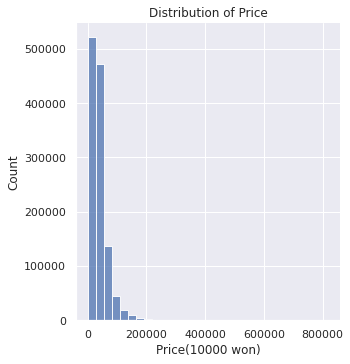

In [110]:
# train price
plt.figure()
sns.displot(train['transaction_real_price'], bins=30)
plt.xlabel('Price(10000 won)')
plt.title('Distribution of Price')
plt.show()

In [111]:
# 가격 로그 변환 후 원래 가격 따로 저장
train['log_price'] = np.log1p(train['transaction_real_price'])
real_price = train['transaction_real_price'] # 원래 가격
train.drop('transaction_real_price', axis=1, inplace=True)
train.head(1)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,apt_counts,top10,transformed,log_price
0,0,7622,서울특별시,137,6-13,23,신교동 6-13 신현(101동),84.82,41,0,21~31,6,13,0,False,10.532123


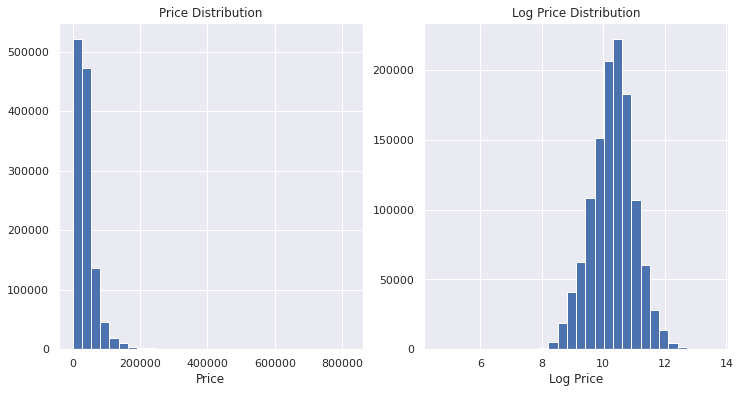

In [112]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_price, bins=30)
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price')

ax2.hist(train['log_price'], bins=30)
ax2.set_title('Log Price Distribution')
ax2.set_xlabel('Log Price')

plt.show()

<Figure size 432x288 with 0 Axes>

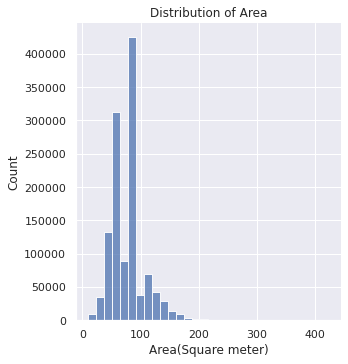

In [113]:
# train area
plt.figure()
sns.displot(train['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

In [114]:
# 면적 로그 변환 후 원래 면적 따로 저장
train['log_area'] = np.log1p(train['exclusive_use_area'])
test['log_area'] = np.log1p(test['exclusive_use_area'])
area = train_df['exclusive_use_area'] # 원래 가격
train.drop('exclusive_use_area', axis=1, inplace=True)
test.drop('exclusive_use_area', axis=1, inplace=True)
train_df.head(1)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10,transformed
0,0,7622,서울특별시,신교동,23,84.82,41,0,2,37500,13,0,False


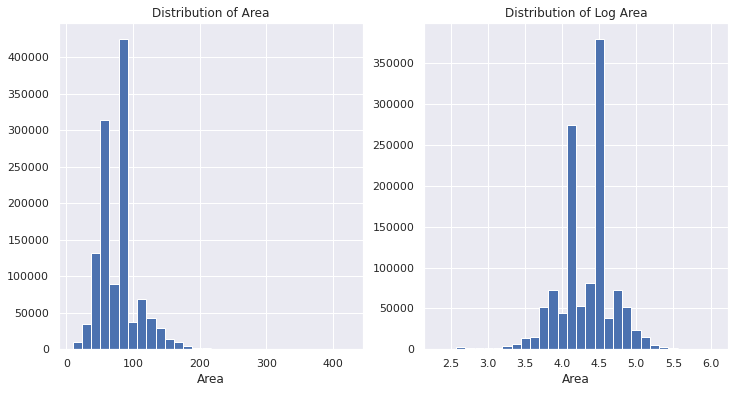

In [115]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(area, bins=30)
ax1.set_title('Distribution of Area')
ax1.set_xlabel('Area')

ax2.hist(train['log_area'], bins=30)
ax2.set_title('Distribution of Log Area')
ax2.set_xlabel('Area')

plt.show()

In [116]:
#서울이면 1, 부산이면 0 /학습에 사용하지 않을 피쳐들도 제거
drop_col = ['transaction_id', 'apartment_id', 'apt_counts', 'transformed']

train['city'] = train['city'].map(lambda x: 1 if x == '서울특별시' else 0)
test['city'] = test['city'].map(lambda x: 1 if x == '서울특별시' else 0)

In [117]:
train.drop(drop_col, axis=1, inplace=True)
test.drop(drop_col, axis=1, inplace=True)
train.head(1)

,city,dong,jibun,apt,addr_kr,year_of_completion,transaction_year_month,transaction_date,floor,top10,log_price,log_area
0,1,137,6-13,23,신교동 6-13 신현(101동),41,0,21~31,6,0,10.532123,4.452252


In [118]:
test.head(1)

,city,dong,jibun,apt,addr_kr,year_of_completion,transaction_year_month,transaction_date,floor,top10,log_area
0,1,50,938,23,목동 938 청학,41,118,11~20,3,0,3.598681


In [119]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216553 entries, 0 to 1216552
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   city                    1216553 non-null  int64  
 1   dong                    1216553 non-null  object 
 2   jibun                   1216553 non-null  object 
 3   apt                     1216553 non-null  object 
 4   addr_kr                 1216553 non-null  object 
 5   year_of_completion      1216553 non-null  int64  
 6   transaction_year_month  1216553 non-null  int64  
 7   transaction_date        1216553 non-null  object 
 8   floor                   1216553 non-null  int64  
 9   top10                   1216553 non-null  int64  
 10  log_price               1216553 non-null  float64
 11  log_area                1216553 non-null  float64
dtypes: float64(2), int64(5), object(5)
memory usage: 152.9+ MB


In [120]:
#dong과 apt object -> int로 변환
#XGBoost와 LightGBM에서 오류가 발생하기 때문

train['dong'] = train['dong'].astype('int64')
train['apt'] = train['apt'].astype('int64')
test['dong'] = test['dong'].astype('int64')
test['apt'] = test['apt'].astype('int64')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216553 entries, 0 to 1216552
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   city                    1216553 non-null  int64  
 1   dong                    1216553 non-null  int64  
 2   jibun                   1216553 non-null  object 
 3   apt                     1216553 non-null  int64  
 4   addr_kr                 1216553 non-null  object 
 5   year_of_completion      1216553 non-null  int64  
 6   transaction_year_month  1216553 non-null  int64  
 7   transaction_date        1216553 non-null  object 
 8   floor                   1216553 non-null  int64  
 9   top10                   1216553 non-null  int64  
 10  log_price               1216553 non-null  float64
 11  log_area                1216553 non-null  float64
dtypes: float64(2), int64(7), object(3)
memory usage: 152.9+ MB
